In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import folium
import branca.colormap as cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from sklearn.preprocessing import StandardScaler

Initial EDA, previous analysis of the provided longitude and latitude data found that this data was 'garbage' so I will use data sourced from the US government to match town location with coordinates on map

The Areas list the specific locations we are interested in and we wish to merge the location data to get the GPS coords of each area

In [2]:
df = pd.read_csv('./boston_corrected_corrected.csv')
df['TOWN']= df['TOWN'].apply(lambda x: x.replace('Boston ','')) #Remove Boston from front of name, this will be useful when merging locaiton dataset

print(df.head())
print(df.shape)
print(df.columns)
print(df.TOWN.unique())

   Unnamed: 0        TOWN  TOWNNO  TRACT        LON        LAT  MEDV  CMEDV  \
0           0      Nahant       0   2011 -70.927800  42.426000  24.0   24.0   
1           1  Swampscott       1   2021 -70.919764  42.481455  21.6   21.6   
2           2  Swampscott       1   2022 -70.897264  42.473777  34.7   34.7   
3           3  Marblehead       2   2031 -70.884407  42.490840  33.4   33.4   
4           4  Marblehead       2   2032 -70.874764  42.499371  36.2   36.2   

      CRIM    ZN  ...  CHAS    NOX     RM   AGE     DIS  RAD  TAX  PTRATIO  \
0  0.00632  18.0  ...     0  0.538  6.575  65.2  4.0900    1  296     15.3   
1  0.02731   0.0  ...     0  0.469  6.421  78.9  4.9671    2  242     17.8   
2  0.02729   0.0  ...     0  0.469  7.185  61.1  4.9671    2  242     17.8   
3  0.03237   0.0  ...     0  0.458  6.998  45.8  6.0622    3  222     18.7   
4  0.06905   0.0  ...     0  0.458  7.147  54.2  6.0622    3  222     18.7   

        B  LSTAT  
0  396.90   4.98  
1  396.90   9.14  

Read in and analyze uslocations data, then merge it with boston dataset

In [3]:
uslocations = pd.read_csv('./US.txt',delimiter = '\t',header =None)
uslocations  = uslocations[uslocations.iloc[:,3] == 'Massachusetts']
uslocations = uslocations.rename(columns = {2:'TOWN',9:'Lat',10:'Lon'})
# uslocations[uslocations.duplicated(subset=['TOWN'],keep=False)]
uslocations = uslocations[['TOWN','Lat','Lon']]
print(uslocations.shape)
uslocations = uslocations.drop_duplicates(['TOWN'])
print(uslocations.shape)
print(uslocations.TOWN.nunique())

df = df.set_index('TOWN').join(uslocations.set_index('TOWN'), how = 'left').reset_index()

(684, 3)
(510, 3)
510


Check which towns weren't located and manually impute data with google search :(

In [5]:
df[df.Lat.isnull()]['TOWN'].unique()

array(['Allston-Brighton', 'Back Bay', 'Beacon Hill', 'Downtown',
       'East Boston', 'Forest Hills', 'North End', 'Sargus', 'Savin Hill',
       'South Boston'], dtype=object)

In [6]:
ManualImputation = {'Allston-Brighton':[42.3539,-71.1337],'Back Bay': [42.3503, -71.0810], 'Beacon Hill': [42.3588, -71.0707], 'Downtown': [42.3557, -71.0572], 'East Boston': [42.3702, -71.0389], 'Forest Hills':[40.7181, -73.8448], 'North End':[42.3647, -71.0542], 'Sargus':[42.4651, -71.0110], 'Savin Hill':[42.3099, -71.0500], 'South Boston':[42.3381, -71.0476]}

In [7]:
for key in ManualImputation:
    for town in df.TOWN.unique():
        if key == town:
            print(town)
            df.loc[df['TOWN']==town, 'Lat']= ManualImputation[key][0]
            df.loc[df['TOWN']==town, 'Lon']= ManualImputation[key][1]

Allston-Brighton
Back Bay
Beacon Hill
Downtown
East Boston
Forest Hills
North End
Sargus
Savin Hill
South Boston


Check that all the towns have been taken care of!

In [8]:
df[df.Lat.isnull()]['TOWN'].unique()

array([], dtype=object)

No missing values, all the towns are described! Let us now plot all of the locaitons

Plot the data with folium

In [10]:
from selenium import webdriver

def VisualPlot(metric, title, use_new_provided_data = False, save= False):
    loc = title
    title_html = ''' <h3 align="center" style="font-size:16px"><b>{}</b></h3>'''.format(loc)   
    minval = df[metric].min()
    maxval = df[metric].max()

    colormap = cm.LinearColormap(colors=['blue','purple','violet','red'], index=[minval,(3*minval+maxval)/4,(3*maxval+minval)/4,maxval],vmin=minval,vmax=maxval) 
    if use_new_provided_data:
        lat = list(df.LAT)
        lon = list(df.LON)
    else:
        lat = list(df.Lat)
        lon = list(df.Lon)
    Metr = list(df[metric])

    m = folium.Map([42.3,-71.1],zoom_start=10)
    for loc, p in zip(zip(lat, lon), Metr):
        folium.Circle(radius = 200,location = loc,fill =True, color = colormap(p),crs = 'EPSG4326').add_to(m)
        
        #BS saving stuff
    m.add_child(colormap)
    m.get_root().html.add_child(folium.Element(title_html))
    display(m)
    if save:
        fn='testmap.html'
        tmpurl='file://{path}/{mapfile}'.format(path=os.getcwd(),mapfile=fn)
        m.save(fn)
        delay = 5
        browser = webdriver.Chrome()
        browser.get(tmpurl)
        time.sleep(delay)
        browser.save_screenshot('map.png')
        browser.quit()    



Lets plot some metrics using my geographical data and AI hack's new provided data:


In [11]:
VisualPlot('CMEDV', 'Median House Price using City Location', use_new_provided_data = False)

Looks good! We know that Beacon ill and Back Bay are notoriously expensive areas within Boston. Lets use ICDSS data:

In [12]:
VisualPlot('CMEDV', 'Median House Price using City Location', use_new_provided_data = True)

It looks like there is a degree of "spacial spillover" when it comes to house prices, perhaps we could make a self-organizing map based on house prices to use i nour model

In [13]:
from sklearn.cluster import KMeans

We will play around with cluster numbers to minimize the clustering distance score

In [14]:
X= np.array([df.LON,df.LAT]).T

for i in range(5,25):
    kmeans = KMeans(n_clusters = i,random_state=42).fit(X)
    y_kmeans = kmeans.predict(X)
    # plt.scatter(X[:, 0], X[:, 1], s=50);
    # plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')
    print(f'Score with {i} clusters = ', kmeans.score(X))

Score with 5 clusters =  -3.3358561931495916
Score with 6 clusters =  -2.6903095293912545
Score with 7 clusters =  -2.306757689738836
Score with 8 clusters =  -1.9490510468694084
Score with 9 clusters =  -1.6243065379711898
Score with 10 clusters =  -1.4438213567657339
Score with 11 clusters =  -1.3209968686043654
Score with 12 clusters =  -1.2058576102033962
Score with 13 clusters =  -1.1288850115059723
Score with 14 clusters =  -1.032566107312071
Score with 15 clusters =  -0.9539623744064399
Score with 16 clusters =  -0.9162325133634919
Score with 17 clusters =  -0.8474845050260883
Score with 18 clusters =  -0.817748747965095
Score with 19 clusters =  -0.7674865207523094
Score with 20 clusters =  -0.7329855627462133
Score with 21 clusters =  -0.7066820868379423
Score with 22 clusters =  -0.6664597610716453
Score with 23 clusters =  -0.6392327468661876
Score with 24 clusters =  -0.6215398326090575


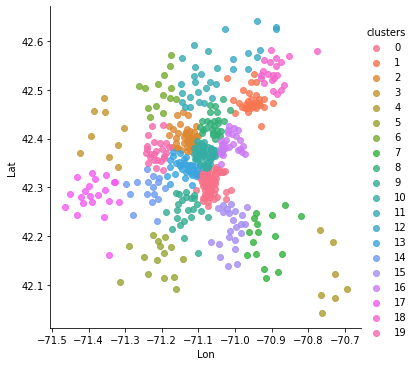

In [15]:
X= np.array([df.LON,df.LAT]).T

clusters = 20
kmeans = KMeans(n_clusters = clusters,random_state=42).fit(X)

clusterdf = pd.DataFrame({'Lon':X[:,0],'Lat':X[:,1],'clusters':kmeans.predict(X),'House Price':df['CMEDV']})
clusterdf['House Price'] = clusterdf['House Price'].apply(lambda x: round(x))
y_kmeans = kmeans.predict(X)
facet = sns.lmplot(data=clusterdf, x='Lon', y='Lat',hue='clusters',
                   fit_reg=False, legend_out=True)

Now we will apply the clustering to the dataframe and attempt to regress it with the price

In [17]:
df['cluster region'] = kmeans.predict(df[['LON','LAT']])
VisualPlot('cluster region', 'Spatial Distribution of Cluster Regions', True)


Determine if there is correlation between clustering zone and CMEDV

In [18]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split


In [19]:
ohe = OneHotEncoder(sparse=False)
ohe.fit_transform(df[['cluster region']])
catdf =  pd.DataFrame(ohe.fit_transform(df[['cluster region']]), columns = list(ohe.categories_[0]))


r2 score of regression fit between cluster location and house price = 0.4273649005200476


Text(0.5, 0, 'Cluster Group')

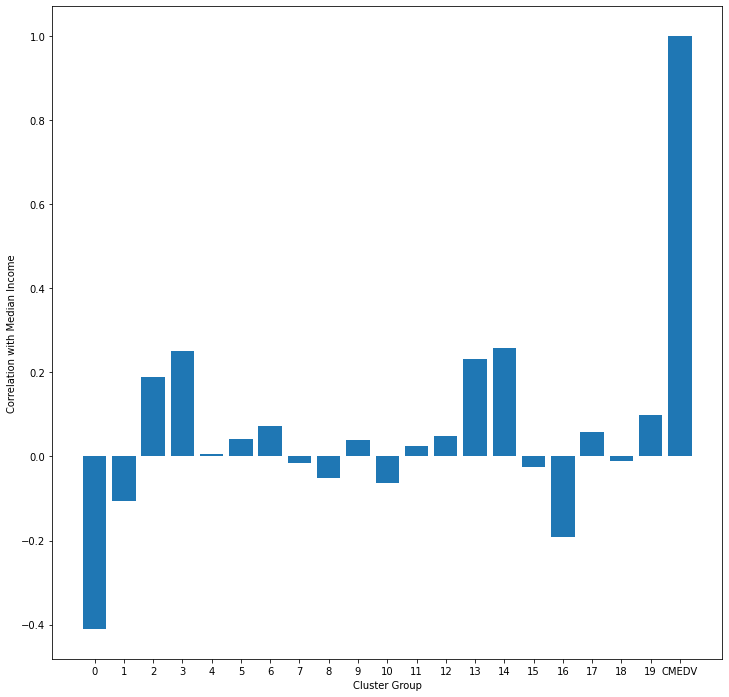

In [20]:

reg = LinearRegression().fit(catdf, df['CMEDV'])
print('r2 score of regression fit between cluster location and house price = {}'.format(reg.score(catdf, df['CMEDV'])))
X=catdf
y = df['CMEDV']
correlations = pd.concat([X,y],axis =1).corr()['CMEDV']
corr_list = list(correlations.index)
list_string = list(map(str, corr_list))  
fig,ax = plt.subplots(figsize = (12,12))
ax.bar(list_string, correlations.values)
ax.set_ylabel('Correlation with Median Income')
ax.set_xlabel('Cluster Group')

Ok thats true as well: we know that South downtown boston (or cluster 0) is pretty low when it comes to house prices
And 13 and 14 are around Beacon Hill which is priceeeeeyyy

Lets see if we can boost a simple linear regression model by using this spatial data! 
Performing linear regression without sptial cluster data:

In [26]:
df1 = df.drop(['LAT','LON','Lat','Lon','TOWN','MEDV','Unnamed: 0','TOWNNO','cluster region'],axis=1)
dfnew = pd.concat([df1, catdf],axis=1)
X = df1.drop(['CMEDV'],axis = 1)
y = df1.CMEDV

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25, random_state=42)

In [27]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
reg = LinearRegression()
reg.fit(X_train,y_train)
print(f'Test Score (r2) = {reg.score(X_test,y_test)}')
print(f'Train Score (r2) = {reg.score(X_train,y_train)}')
base_score = reg.score(X_test,y_test)


Test Score (r2) = 0.7131337360856936
Train Score (r2) = 0.752860087334136


Now attempting Linear Regression with all the features

In [28]:
dfnew.head()
print(dfnew.columns)

Index([  'TRACT',   'CMEDV',    'CRIM',      'ZN',   'INDUS',    'CHAS',
           'NOX',      'RM',     'AGE',     'DIS',     'RAD',     'TAX',
       'PTRATIO',       'B',   'LSTAT',         0,         1,         2,
               3,         4,         5,         6,         7,         8,
               9,        10,        11,        12,        13,        14,
              15,        16,        17,        18,        19],
      dtype='object')


In [29]:
X = dfnew.drop(['CMEDV'],axis = 1)
y = dfnew.CMEDV

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
reg = LinearRegression()
reg.fit(X_train,y_train)
print(f'Test Score (r2) = {reg.score(X_test,y_test)}')
print(f'Train Score (r2) = {reg.score(X_train,y_train)}')
#We can see a slight increase in performance when performing linear regression... nice!

Test Score (r2) = 0.7541256964893126
Train Score (r2) = 0.8039637140297059


But the fact that there is only a slight performance boost to the model when including the clustered data suggests that a lot of the spatial data is captured in other variables, let's see if this is highly dependent on the number of clusters!

In [35]:
def LinRegSpacialReg(df,n_clusters,random_state,printval=True):
    clusters = n_clusters
    X= np.array([df.LON,df.LAT]).T
    kmeans = KMeans(n_clusters = clusters,random_state=10).fit(X)
    df['cluster region'] = kmeans.predict(df[['LON','LAT']])
    #OHE
    ohe = OneHotEncoder(sparse=False)
    ohe.fit_transform(df[['cluster region']])
    catdf =  pd.DataFrame(ohe.fit_transform(df[['cluster region']]), columns = list(ohe.categories_[0]))
    df1 = df.drop(['LAT','LON','TOWN','MEDV','Unnamed: 0','TOWNNO','cluster region'],axis=1)
    dfnew = pd.concat([df1, catdf],axis=1)
    X = dfnew.drop(['CMEDV'],axis = 1)
    y = dfnew.CMEDV
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25, random_state=random_state)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    reg = LinearRegression()
    reg.fit(X_train,y_train)
    perfincrease = reg.score(X_test,y_test)-base_score
    if printval:
        print(f'Test Score (r2) = {reg.score(X_test,y_test)}')
        print(f'Train Score (r2) = {reg.score(X_train,y_train)}')
        print(f'Test Performance Increase = {perfincrease}')
    return perfincrease

Now lets see what sort of performance increase we can get by changing the number of clusters

In [33]:
LinRegSpacialReg(df,15,random_state=22)


Test Score (r2) = 0.8080066177260139
Train Score (r2) = 0.7530943563743744
Test Performance Increase = 0.09487288164032026


0.09487288164032026

How general is this pattern? If we look at different train test splits (by manipulating random_state) and use different cluster sizes, is there a trend??

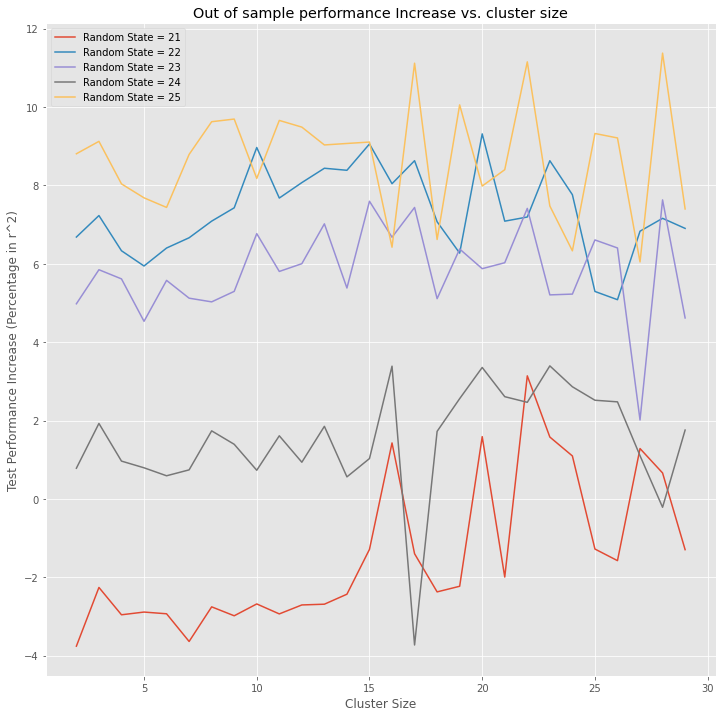

In [37]:
plt.style.use('ggplot')
clusternum = range(2,30)
fig, ax = plt.subplots(figsize = (12,12))
ax.set_xlabel('Cluster Size')
ax.set_ylabel('Test Performance Increase (Percentage in r^2)')
plt.title('Out of sample performance Increase vs. cluster size')

for random_state in range(21,26):
    performance = []
    for i in clusternum:
        performance.append(LinRegSpacialReg(df,i,printval= False,random_state=random_state))

    ax.plot(clusternum,np.array(performance)*100, label = f'Random State = {random_state}')
plt.legend()

 larger cluster size certainly improves performance slightly, however we would hope for reasonable performance over a range of train_test splits...